# Sentiment Anaylsis Project 
### -> Dataset IMDB 50k movie reviews

###### --> Name - Parth Bhardwaj
###### --> Course - B.Tech CSE AIML - E 
###### --> ROLL NO. 2301730289

### Importing Libraries

In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re
import string

import pickle

import warnings
warnings.filterwarnings('ignore')

# ==== NLP Libraries ====
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# ==== Machine Learning Libraries ====
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

plt.style.use('ggplot')
sns.set(style='whitegrid')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bhard\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bhard\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bhard\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Loading Dataset(IMDB 50k reviews) and Overiew

In [6]:
df = pd.read_csv("./IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
df.tail()

,review,sentiment
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative
49999,No one expects the Star Trek movies to be high...,negative


In [8]:
df.shape

(50000, 2)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [10]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [11]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [12]:
df['review_length']=df['review'].apply(len)
df['review_word_count']=df['review'].apply(lambda x: len(x.split()))
df.describe()

,review_length,review_word_count
count,50000.000000,50000.000000
mean,1309.431020,231.156940
std,989.728014,171.343997
min,32.000000,4.000000
25%,699.000000,126.000000
50%,970.000000,173.000000
75%,1590.250000,280.000000
max,13704.000000,2470.000000


In [13]:
df.duplicated().sum()

np.int64(418)

In [14]:
df[df.duplicated()].head()

,review,sentiment,review_length,review_word_count
3537,Quite what the producers of this appalling ada...,negative,2308,401
3769,My favourite police series of all time turns t...,positive,488,94
4391,"Beautiful film, pure Cassavetes style. Gena Ro...",positive,696,110
6352,If you liked the Grinch movie... go watch that...,negative,548,100
6479,I want very much to believe that the above quo...,negative,2750,446


In [15]:
df_positive = df[df['sentiment']=='positive'][:9000]
df_negative = df[df['sentiment']=='negative'][:1000]

df_review_imdb = pd.concat([df_positive,df_negative ])

### Tackling Imbalanced Classes

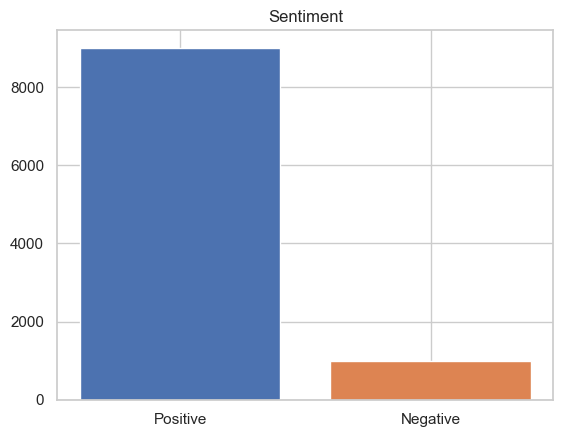

In [16]:
colors = sns.color_palette('deep')

plt.bar(x = ['Positive', 'Negative'], height = df_review_imdb.value_counts(['sentiment']), color = colors[:2])
plt.title('Sentiment')
plt.show()

In [17]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state= 0)
df_review_bal,df_review_bal['sentiment']=rus.fit_resample(df_review_imdb[['review']],df_review_imdb['sentiment'])


df_review_bal

,review,sentiment
3,Basically there's a family where a little boy ...,negative
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
10,Phil the Alien is one of those quirky films wh...,negative
11,I saw this movie when I was about 12 when it c...,negative
...,...,...
10833,Knute Rockne led an extraordinary life and his...,positive
1039,At the height of the 'Celebrity Big Brother' r...,positive
5255,This is another of Robert Altman's underrated ...,positive
12237,This movie won a special award at Cannes for i...,positive


In [18]:
print(df_review_imdb.value_counts('sentiment'))
print(df_review_bal.value_counts('sentiment'))

sentiment
positive    9000
negative    1000
Name: count, dtype: int64
sentiment
negative    1000
positive    1000
Name: count, dtype: int64


### Splitting data into train and test set


In [19]:
from sklearn.model_selection import train_test_split

train,test = train_test_split(df_review_bal,test_size =0.33,random_state=42)

In [20]:
train_x, train_y = train['review'], train['sentiment']
test_x, test_y = test['review'], test['sentiment']

In [21]:
train_y.value_counts()


sentiment
negative    675
positive    665
Name: count, dtype: int64

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english')
train_x_vector = tfidf.fit_transform(train_x)
# also fit the test_x_vector
test_x_vector = tfidf.transform(test_x)

In [23]:
pd.DataFrame.sparse.from_spmatrix(
    train_x_vector,
    index=train_x.index,
    columns=tfidf.get_feature_names_out()
)


,00,000,007,01pm,02,04,08,10,100,1000,...,zooming,zooms,zues,zzzzzzzzzzzzzzzzzz,æon,élan,émigré,ísnt,ïn,ünfaithful
144,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1839,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16588,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
742,0,0,0,0,0,0,0,0.042791,0,0,...,0,0,0,0,0,0,0,0,0,0
9464,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10644,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16133,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1739,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2443,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Model Selection


#### SVM


In [24]:
from sklearn.svm import SVC
svc = SVC(kernel='linear')
svc.fit(train_x_vector, train_y)

SVC(kernel='linear')

In [25]:
print(svc.predict(tfidf.transform(['Absolutely loved this movie'])))
print(svc.predict(tfidf.transform(['Terrible screen play'])))
print(svc.predict(tfidf.transform(['poor devliery of dialouges'])))

['positive']
['negative']
['negative']


#### Desicion Treee


In [26]:
from sklearn.tree import DecisionTreeClassifier
dec_tree = DecisionTreeClassifier()
dec_tree.fit(train_x_vector, train_y)

DecisionTreeClassifier()

#### Naive Bayees


In [27]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(train_x_vector.toarray(), train_y)

GaussianNB()

#### Logistic Regression


In [28]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(train_x_vector,train_y)

LogisticRegression()

### Model Evaluation

#### Mean Accuracy

In [29]:
print(svc.score(test_x_vector, test_y))
print(dec_tree.score(test_x_vector, test_y))
print(gnb.score(test_x_vector.toarray(), test_y))
print(log_reg.score(test_x_vector, test_y))

0.8409090909090909
0.6454545454545455
0.6348484848484849
0.8303030303030303


#### F1 Score

In [30]:
from sklearn.metrics import f1_score

f1_score(test_y,svc.predict(test_x_vector),
          labels = ['positive','negative'],average=None)

array([0.84671533, 0.83464567])

#### Classification Report


In [31]:
from sklearn.metrics import classification_report

print(classification_report(test_y,
                            svc.predict(test_x_vector),
                            labels = ['positive','negative']))

              precision    recall  f1-score   support

    positive       0.83      0.87      0.85       335
    negative       0.85      0.82      0.83       325

    accuracy                           0.84       660
   macro avg       0.84      0.84      0.84       660
weighted avg       0.84      0.84      0.84       660



#### Confusion Matrix

In [32]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(test_y,
                           svc.predict(test_x_vector),
                           labels = ['positive', 'negative'])
conf_mat


array([[290,  45],
       [ 60, 265]])

#### Fine Tuning Model


In [33]:
from sklearn.model_selection import GridSearchCV
#set the parameters
params = {'C': [1,4,8,16,32], 'kernel' : ['linear','rbf']}
svc = SVC()
svc_grid = GridSearchCV(svc,params, cv = 5)
svc_grid.fit(train_x_vector, train_y)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 4, 8, 16, 32], 'kernel': ['linear', 'rbf']})

In [34]:
print(svc_grid.best_params_)
print(svc_grid.best_estimator_)

{'C': 1, 'kernel': 'linear'}
SVC(C=1, kernel='linear')
